# Laboratorio 5
## Universidad del Valle de Guatemala <br> Facultas de Ingeniería
#### Departamento de Ciencias de la Computación <br> Deep Learning y Sistemas Inteligentes - Sección 20 <br> Jeyner Arango 201106 <br> Cristian Laynez 201281

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input, UpSampling2D, Conv2D, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
(X_train, _), (_, _) = mnist.load_data()

X_train = X_train[:10000]
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

In [3]:
noise_dim = 50

In [4]:
generator = Sequential([
    Dense(64 * 7 * 7, input_dim=noise_dim),
    Reshape((7, 7, 64)),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    UpSampling2D(),
    Conv2D(32, (5, 5), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    UpSampling2D(),
    Conv2D(1, (5, 5), padding='same', activation='tanh')
])

In [5]:
discriminator = Sequential([
    Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [6]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

In [7]:
discriminator.trainable = False

In [8]:
gan_input = Input(shape=(noise_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

In [9]:
def train_gan(epochs=1, batch_size=64):
    batch_count = X_train.shape[0] // batch_size

    for e in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=[batch_size, noise_dim])
            generated_images = generator.predict(noise)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]

            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9  # Etiquetas suavizadas

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)

            noise = np.random.normal(0, 1, size=[batch_size, noise_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)

        print(f'Época {e}:\tD Loss: {d_loss[0]} | Accuracy: {100 * d_loss[1]}%\tG Loss: {g_loss}')

In [10]:
train_gan(epochs=50, batch_size=64)

2/2 [==============================] - 0s 15ms/step
Época 0:	D Loss: 0.388584703207016 | Accuracy: 50.0%	G Loss: 0.449784517288208
2/2 [==============================] - 0s 13ms/step
Época 1:	D Loss: 0.5968917608261108 | Accuracy: 39.0625%	G Loss: 0.9229283332824707
2/2 [==============================] - 0s 18ms/step
Época 2:	D Loss: 0.6423298120498657 | Accuracy: 42.1875%	G Loss: 0.9428537487983704
2/2 [==============================] - 0s 12ms/step
Época 3:	D Loss: 0.7093278169631958 | Accuracy: 37.5%	G Loss: 0.7337457537651062
2/2 [==============================] - 0s 12ms/step
Época 4:	D Loss: 0.6697454452514648 | Accuracy: 46.875%	G Loss: 0.8288956880569458
2/2 [==============================] - 0s 11ms/step
Época 5:	D Loss: 0.6685311794281006 | Accuracy: 46.09375%	G Loss: 0.8670210838317871
2/2 [==============================] - 0s 14ms/step
Época 6:	D Loss: 0.6620769500732422 | Accuracy: 39.0625%	G Loss: 0.8072283267974854
2/2 [==============================] - 0s 12ms/step
Époc

In [11]:
noise = np.random.normal(0, 1, size=[16, noise_dim])
generated_images = generator.predict(noise)

1/1 [==============================] - 0s 162ms/step


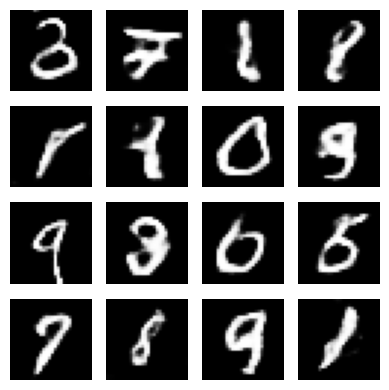

In [12]:
plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()